# Thesis project notebook 

##### Uncomment and run the cell below to automatically install the required libraries

In [1]:
# %pip install -r requirements.txt

Start by importing the required libraries

In [2]:
import json
import os
from multiprocessing import Pool
import pandas as pd
import utils
import time
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error
import statistics

Let's load in the search terms we need to use

In [3]:
terms = pd.read_csv(f'{os.getcwd()}\\Data\\search.tsv', sep='\t') # obtained from https://ahrefs.com/blog/top-youtube-searches/
terms.head(10)

,#,Keyword,Search Volume
0,1,bts,"16,723,304"
1,2,pewdiepie,"16,495,659"
2,3,asmr,"14,655,088"
3,4,billie eilish,"13,801,247"
4,5,baby shark,"12,110,100"
5,6,old town road,"10,456,524"
6,7,music,"10,232,134"
7,8,badabun,"10,188,997"
8,9,blackpink,"9,580,131"
9,10,fortnite,"9,117,342"


We can use these search terms to get YouTube video links which we can then use to gather comments. To save some time (and some precious API quota) we'll use the top 50 searched terms

This cell should not be run more than once a month. To make sure you never have to run it again, save the output to a file and load it for subsequent runs

In [4]:
###---###

from get_video import get_videos
half = terms.head(50)
search_terms = half["Keyword"]
urls = []

for term in search_terms:
    urls.append(get_videos(term))

links = list(set(item for sublist in urls for item in sublist))

with open(f"{os.getcwd()}\\Data\\videos__.json", "w") as f:
    json.dump(links, f)

In [5]:
with open(f"{os.getcwd()}\\Data\\videos__.json", "r") as f:
    links = json.load(f)

print(f"This file contains <{len(links)}> links")

This file contains <911> links


This is a lot of links (and therefore a lot of data). However, taking into account the rate of analysis and the amount of comments per video, we realize that it's going to take a lot of time: many of these videos have around 20,000 comments minimum. Knowing that it takes this program around 30 seconds to analyze 100 comments, analyzing all comments would take days. 

Instead of waiting for 9 days, we can make a compromise: we can take a sample of 500 comments per video. 

Now that we have our list of links, we can start collecting data. Let's do the fast part first: collecting the like/dislike ratio and saving it somewhere convenient for later. 

As before, this cell should ideally be run once only as it takes a bit of time - around 15 minutes. If the notebook needs to be restarted, you should load the csv file instead.

In [6]:
###---###
from get_video import get_likes
start_time = time.time()

with open("{os.getcwd()}\\Data\\videos__.json", "r") as f:
    links = json.load(f)
df_list = []

checkpoints = {int(len(links) * perc): perc * 100 for perc in [0.25, 0.5, 0.75, 0.9, 1]} # same as before

for i, link in enumerate(links):
    current_time = time.time()
    elapsed_time = current_time - start_time
    data = get_likes(link)
    df_list.append(data)
    time.sleep(1) # otherwise we will get an HTTP error
    if i + 1 in checkpoints:
        print(f"{checkpoints[i+1] :.0f}% of the videos have been analyzed\nTime elapsed: {elapsed_time :.2f} seconds")  
     
df = pd.DataFrame(df_list)
utils.save_analysis(df, "top50_ratio")

Let's look at the first 10 entries

In [7]:
likes_df = pd.read_csv(f"{os.getcwd()}\\Data\\analysis_top50_ratio.csv", index_col = 0)
likes_df = likes_df.reset_index()
likes_df.head(10)

,URL,likes,dislikes
0,https://www.youtube.com/watch?v=feLcMaiClOw,312761,19093
1,https://www.youtube.com/watch?v=tASwv-tkMlc,35026,165
2,https://www.youtube.com/watch?v=3U2dNKBM28o,126427,6010
3,https://www.youtube.com/watch?v=1cPDfXU95Xw,23783,18
4,https://www.youtube.com/watch?v=pptIU_ZLlOo,4600,7
5,https://www.youtube.com/watch?v=ClQ-ymoXJZc,1079676,8874
6,https://www.youtube.com/watch?v=8EJ3zbKTWQ8,11371069,1420624
7,https://www.youtube.com/watch?v=t99KH0TR-J4,1435738,33092
8,https://www.youtube.com/watch?v=DovdIspaqmw,146007,5324
9,https://www.youtube.com/watch?v=DQQRjFzB8gY,870202,49922


This is good data, but it is not complete. We are still missing the ratio of likes to dislikes. Let's compute that now!

In [8]:
likes, dislikes = likes_df['likes'], likes_df['dislikes']

ratios = []

for like, dislike in zip(likes, dislikes):
    if like == 0 or dislike == 0:
        ratio = 0
        ratios.append(ratio)
    else:
        ratio = round(like / dislike, 3)
        ratios.append(ratio)

ratios = pd.Series(ratios)
ratios.head(10)

0      16.381
1     212.279
2      21.036
3    1321.278
4     657.143
5     121.667
6       8.004
7      43.386
8      27.424
9      17.431
dtype: float64

Let's add this list to our dataframe and compute the mean ratio

In [9]:
likes_df['ratio'] = ratios.astype('float64') 
mean_ratio = ratios.mean()
print(f"Mean like/dislike ratio = {mean_ratio :.2f}")
likes_df.head(10)

Mean like/dislike ratio = 123.55


,URL,likes,dislikes,ratio
0,https://www.youtube.com/watch?v=feLcMaiClOw,312761,19093,16.381
1,https://www.youtube.com/watch?v=tASwv-tkMlc,35026,165,212.279
2,https://www.youtube.com/watch?v=3U2dNKBM28o,126427,6010,21.036
3,https://www.youtube.com/watch?v=1cPDfXU95Xw,23783,18,1321.278
4,https://www.youtube.com/watch?v=pptIU_ZLlOo,4600,7,657.143
5,https://www.youtube.com/watch?v=ClQ-ymoXJZc,1079676,8874,121.667
6,https://www.youtube.com/watch?v=8EJ3zbKTWQ8,11371069,1420624,8.004
7,https://www.youtube.com/watch?v=t99KH0TR-J4,1435738,33092,43.386
8,https://www.youtube.com/watch?v=DovdIspaqmw,146007,5324,27.424
9,https://www.youtube.com/watch?v=DQQRjFzB8gY,870202,49922,17.431


We will use the data in this dataframe as the baseline for the sentiment analysis.

This process is going to take a long time to complete, even with multiprocessing. 

Let's start by collecting the comments.
The results will be saved to a file, so there's no need to run this cell more than once if everything goes well.

In [10]:
###---###
from get_video import get_id, get_comments
import googleapiclient.discovery

urls = list(likes_df["URL"])

target_dir = f"{os.getcwd()}/Data"
if not os.path.exists(target_dir):
    os.mkdir(target_dir)

for url in urls:
    video_id = get_id(url)
    try:
        comments = get_comments(url)
    except googleapiclient.errors.HttpError:
        continue
    utils.move_dir(f"comments_{video_id}.json", target_dir)

There is a problem: some of the files have very few comments, and we need at least 500. So, we will have to remove all files with less than 500 comments

In [11]:
###---###
from get_video import load_comments

target_dir = f"{os.getcwd()}\\Data"
trash = f"{os.getcwd()}\\Trash"

checkpoints = {int(len(links) * perc): perc * 100 for perc in [0.25, 0.5, 0.75, 0.9, 1]} # same as before

if not os.path.exists(trash):
    os.mkdir(trash)

data = os.listdir(target_dir)

start =  time.time()

for i, file in enumerate(data):
    current_time = time.time()
    elapsed_time = current_time - start
    filepath = os.path.join(target_dir, file)
    content = load_comments(filepath)
    if len(content) < 500:
        utils.move_dir(filename = file, destination = trash, source = target_dir)
    if i + 1 in checkpoints:
        print(f"{checkpoints[i+1] :.0f}% of the videos have been analyzed\nTime elapsed: {elapsed_time :.2f} seconds") 
trash_list = os.listdir(trash)

print(f"<{len(trash_list)}> files moved")

Quick sanity check:

In [12]:
###---###
target_dir = f"{os.getcwd()}\\Data"

data = os.listdir(target_dir)
print(f"This directory contains <{len(data)}> files")
for file in data:
    filepath = os.path.join(target_dir, file)
    content = load_comments(filepath)
    print(len(content))

Great! We have over 500 videos left, each with at least 500 comments. All that's left to do is run the sentiment analysis on each video. This is going to take a lot of time, which means we'll have to do it in batches. 100 videos per batch seems feasible, so let's do that. 

In [13]:
###---###
%run split_folder__.py ".\Data" 
#Obtained from https://gist.github.com/zupo/5849843

Another sanity check:

In [14]:
###---###
target_dir = f"{os.getcwd()}\\Data\\Batch_1"
data = os.listdir(target_dir)
print(len(data))

Now we can finally start the analysis

In [15]:
###---###
from get_video import load_comments

home_dir = os.getcwd()
batch_1 = f"{os.getcwd()}\\Data\\Batch_1"
data_1 = os.listdir(batch_1)

os.chdir(batch_1)

for file in data_1:
    if file.startswith("analysis_"): 
        continue
    else:
        start = time.time()
        filename = f"{batch_1}\\{file}"
        content = load_comments(filename)

        with Pool() as p:
            tr_comment = p.map(utils.translate, content)

        bert_scores = utils.bert_classifier(content)

        df_list = []
        scores_list = []

        with Pool() as p:
            analysis1 = p.map(utils.vader_classifier, tr_comment)
            analysis2 = p.map(utils.textblob_classifier, tr_comment)
            scores_list.append(analysis1)
            scores_list.append(analysis2)

        for c, v_score, t_score in zip(content, scores_list[0], scores_list[1]):
            df_dict = {
                "Comment": c,
                "Vader score": v_score,
                "TextBlob score": t_score,
            }
            df_list.append(df_dict)

        df = pd.DataFrame(df_list)

        series_bert = pd.Series(bert_scores)
        df["BERT score"] = series_bert

        vader_labels = utils.generate_labels(df["Vader score"], "vader")
        blob_labels = utils.generate_labels(df["TextBlob score"], "blob")
        bert_labels = utils.generate_labels(df["BERT score"], "bert")

        vader_labels_series = pd.Series(vader_labels)
        blob_labels_series = pd.Series(blob_labels)
        bert_labels_series = pd.Series(bert_labels)

        df["Vader label"] = vader_labels_series
        df["TextBlob label"] = blob_labels_series
        df["BERT label"] = bert_labels_series

        df = df[
            [
                "Comment",
                "Vader score",
                "Vader label",
                "TextBlob score",
                "TextBlob label",
                "BERT score",
                "BERT label",
            ]
        ]

        end = time.time()
        time_taken = end - start
        print(f"Processed file <{file}>\nTime taken: <{time_taken}> seconds")
        utils.save_analysis(df, file)

os.chdir(home_dir) # Reset cwd for next batch

Let's copy and merge the CSV files for easier analysis of overall trends

In [16]:
###---###
import shutil

folders = ["Batch_1", "Batch_2", "Batch_3", "Batch_4", "Batch_5", "Batch_6"]
data_dir = f"{os.getcwd()}\\Data"
target_dir = f"{os.getcwd()}\\CSV"

if not os.path.exists(target_dir):
    os.mkdir(target_dir)

for folder in folders:
    batch = f"{data_dir}\\{folder}"
    all_data = os.listdir(batch)
    for file in all_data:
        if file.endswith(".csv"):
            filename = os.path.join(batch, file)
            shutil.copy(filename, target_dir)            

files = os.listdir(target_dir)

combined_csv = pd.concat([pd.read_csv(f"{target_dir}\\{f}") for f in files])
combined_csv.to_csv("analysis_all_files.csv", index=False, encoding="utf-8-sig")

all_files = pd.read_csv(f"{target_dir}\\analysis_all_files.csv")
all_files.head(10)

Let's get a ratio of polarities for all videos for each model and visualize it in a graph

In [17]:
# Setting up plots for display in LaTeX
import matplotlib
%matplotlib inline
plots_dir = f"{os.getcwd()}\\Plots"
#matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

Ratios: 
      Model  Positive   Neutral  Negative
0     Vader  0.507953  0.357239  0.134808
1  TextBlob  0.388648  0.517005  0.094347
2      BERT  0.452432  0.244917  0.302651 



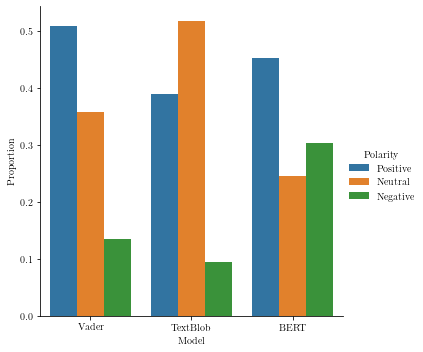

In [18]:
target_dir = f"{os.getcwd()}\\Data\\CSV"
all_files = pd.read_csv(f"{target_dir}\\analysis_all_files.csv")

columns = [all_files["Vader label"], all_files["TextBlob label"], all_files["BERT label"]]
models = ["Vader", "TextBlob", "BERT"]
df_list = []

for column, model in zip(columns, models):
    col = column.value_counts(normalize=True)
    d = {"Model": model, "Positive": col['Positive'], "Neutral": col['Neutral'], "Negative": col['Negative']}
    df_list.append(d)

all_ratios = pd.DataFrame(df_list)
print("Ratios: ")
print(all_ratios, "\n")

proportion = all_ratios.melt("Model", var_name = "Polarity", value_name = "Proportion")
g = sns.catplot(x = "Model", y = "Proportion", hue="Polarity", data = proportion, kind = "bar")
# plt.savefig(f"{plots_dir}\\proportion_labels.pgf", dpi = 300)
plt.show()

Vader and BERT seem to be relatively close to each other in the ratio of their predictions, while TextBlob does not seem to follow the trend. 
Let's check if the predictions correlate:

In [19]:
print("Statistics: ")
print(all_files.describe(), "\n")

print("Correlation matrix: ")
print(all_files.corr("pearson"))

Statistics: 
         Vader score  TextBlob score     BERT score
count  339364.000000   339364.000000  339364.000000
mean        0.255158        0.149271       0.204303
std         0.448403        0.324981       0.459851
min        -1.000000       -1.000000      -0.988600
25%         0.000000        0.000000      -0.293853
50%         0.090000        0.000000       0.308578
75%         0.636900        0.350000       0.522687
max         1.000000        1.000000       0.991498 

Correlation matrix: 
                Vader score  TextBlob score  BERT score
Vader score        1.000000        0.524019    0.447403
TextBlob score     0.524019        1.000000    0.446724
BERT score         0.447403        0.446724    1.000000


They seem to all have a slightly positive relationship, which means that they are correlated to each other (albeit not very much). Let's visualize the counts for each label (for each model) in a graph

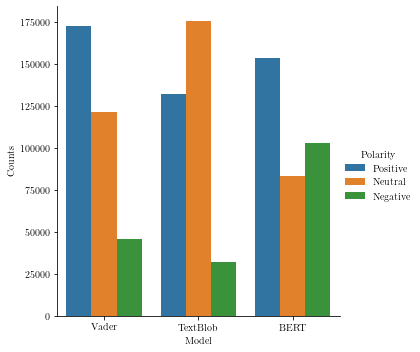

In [20]:
columns = [all_files["Vader label"], all_files["TextBlob label"], all_files["BERT label"]]
models = ["Vader", "TextBlob", "BERT"]
df_list = []

for column, model in zip(columns, models):
    col = column.value_counts()
    d = {"Model": model, "Positive": col['Positive'], "Neutral": col['Neutral'], "Negative": col['Negative']}
    df_list.append(d)

all_labels = pd.DataFrame(df_list)

counts = all_labels.melt("Model", var_name = "Polarity", value_name = "Counts")
g = sns.catplot(x = "Model", y = "Counts", hue="Polarity", data = counts, kind = "bar")
# plt.savefig(f"{plots_dir}\\count_labels.pgf", dpi = 300)

Let's check the distribution of polarities per model

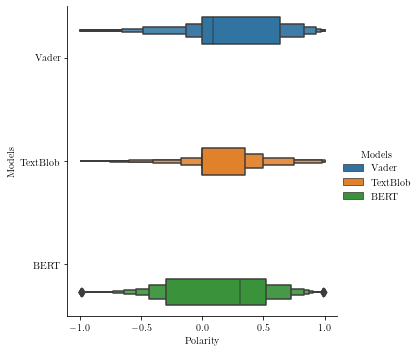

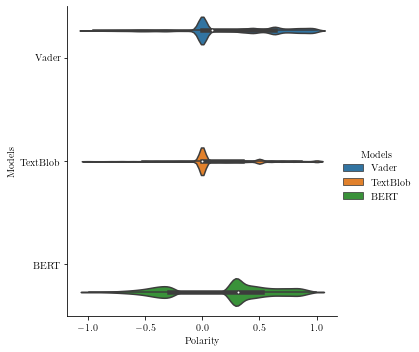

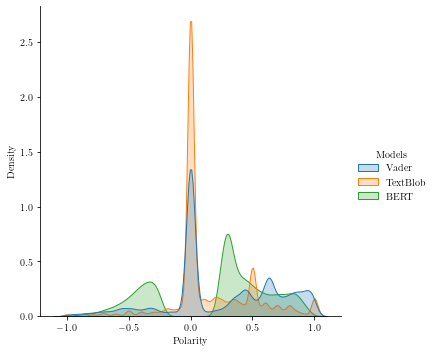

In [40]:
columns = [all_files["Vader score"], all_files["TextBlob score"], all_files["BERT score"]]
models = ["Vader", "TextBlob", "BERT"]
df_list = []

all_files_copy = all_files.copy(deep = True)
all_files_copy = all_files_copy.drop(columns = ["Comment", "Vader label", "TextBlob label", "BERT label"])
all_files_copy = all_files_copy.rename(columns = {"Vader score": "Vader", "TextBlob score": "TextBlob", "BERT score": "BERT"})
all_files_copy_melt = pd.melt(all_files_copy, var_name = "Models", value_name = "Polarity")

boxen = sns.catplot(x = "Polarity", y = "Models", hue="Models", data = all_files_copy_melt, kind = "boxen")
#plt.savefig(f"{plots_dir}\\boxenplot_times.pgf", dpi = 300)

violin = sns.catplot(x = "Polarity", y = "Models", hue="Models", data = all_files_copy_melt, kind = "violin")
#plt.savefig(f"{plots_dir}\\violinplot_times.pgf", dpi = 300)

kde = sns.displot(data = all_files_copy_melt, x = "Polarity", hue="Models", kind = "kde", fill = True)
#plt.savefig(f"{plots_dir}\\polarity_distribution_times.pgf", dpi = 300)

Let's start by making a new likes dataframe based on the videos we analyzed. We can use the ID column to get the corresponding CSV file later on

In [22]:
data = f"{os.getcwd()}\\Data"
csv_dir = f"{os.getcwd()}\\Data\\CSV"
csv_list = os.listdir(csv_dir)

likes_df_short = likes_df.copy(deep = True) # make copy of ratio dataframe
likes_df_short.reset_index(inplace = True)
video_id = [row[-11:] for row in likes_df_short["URL"]] # get video ID from URL ***DON'T USE***
file_id = sorted([file[18:-4] for file in csv_list if file.startswith("analysis_comments")]) # get video ID from filename
common_id = sorted(list(set(video_id).intersection(file_id))) # USE THIS 

likes_df_short["ID"] = pd.Series(video_id) # add to dataframe
likes_df_short = likes_df_short[likes_df_short['ID'].isin(common_id)]
likes_df_short = likes_df_short[["URL", "ID", "likes", "dislikes", "ratio"]]

likes_df_short.head(10)

#likes_df_short.to_csv(f"{csv_dir}\\likes_df_short.csv")

,URL,ID,likes,dislikes,ratio
0,https://www.youtube.com/watch?v=feLcMaiClOw,feLcMaiClOw,312761,19093,16.381
1,https://www.youtube.com/watch?v=tASwv-tkMlc,tASwv-tkMlc,35026,165,212.279
2,https://www.youtube.com/watch?v=3U2dNKBM28o,3U2dNKBM28o,126427,6010,21.036
5,https://www.youtube.com/watch?v=ClQ-ymoXJZc,ClQ-ymoXJZc,1079676,8874,121.667
6,https://www.youtube.com/watch?v=8EJ3zbKTWQ8,8EJ3zbKTWQ8,11371069,1420624,8.004
7,https://www.youtube.com/watch?v=t99KH0TR-J4,t99KH0TR-J4,1435738,33092,43.386
8,https://www.youtube.com/watch?v=DovdIspaqmw,DovdIspaqmw,146007,5324,27.424
9,https://www.youtube.com/watch?v=DQQRjFzB8gY,DQQRjFzB8gY,870202,49922,17.431
10,https://www.youtube.com/watch?v=8DytqFTwNSc,8DytqFTwNSc,88001,2068,42.554
16,https://www.youtube.com/watch?v=2cyzCReoNgU,2cyzCReoNgU,78842,819,96.266


To generate the new engagement metrics we will assign points to each comment based on their polarity: 1 point for positive, 0 for neutral, and -1 for negative and add the sum of those points to the dataframe

In [23]:
files = os.listdir(target_dir)

v_list, t_list, b_list = [], [], []

for id_ in likes_df_short["ID"]: # For each file
    v_score, t_score, b_score  = [], [], []
    filename = f"analysis_comments_{id_}.csv"
    filepath = f"{target_dir}\\{filename}" 
    df = pd.read_csv(filepath)
    for l_v, l_t, l_b in zip(df["Vader label"], df["TextBlob label"], df["BERT label"]): # For each column
        v_score.append(utils.generate_score(l_v))
        t_score.append(utils.generate_score(l_t))
        b_score.append(utils.generate_score(l_b))
    v_list.append(sum(v_score))
    t_list.append(sum(t_score))
    b_list.append(sum(b_score))

v_series = pd.Series(v_list)
t_series = pd.Series(t_list)
b_series = pd.Series(b_list)

v_series.index = likes_df_short.index
t_series.index = likes_df_short.index
b_series.index = likes_df_short.index

likes_df_short["Vader total"] = v_series
likes_df_short["TextBlob total"] = t_series
likes_df_short["BERT total"] = b_series

likes_df_short = likes_df_short[["URL", "ID", "likes", "dislikes", "ratio", "Vader total", "TextBlob total", "BERT total"]]
likes_df_short = likes_df_short.rename(columns = {"ratio":"like/dislike ratio"})
likes_df_short.head(10)

,URL,ID,likes,dislikes,like/dislike ratio,Vader total,TextBlob total,BERT total
0,https://www.youtube.com/watch?v=feLcMaiClOw,feLcMaiClOw,312761,19093,16.381,294,199,-101
1,https://www.youtube.com/watch?v=tASwv-tkMlc,tASwv-tkMlc,35026,165,212.279,365,177,122
2,https://www.youtube.com/watch?v=3U2dNKBM28o,3U2dNKBM28o,126427,6010,21.036,333,253,152
5,https://www.youtube.com/watch?v=ClQ-ymoXJZc,ClQ-ymoXJZc,1079676,8874,121.667,154,105,-49
6,https://www.youtube.com/watch?v=8EJ3zbKTWQ8,8EJ3zbKTWQ8,11371069,1420624,8.004,255,155,153
7,https://www.youtube.com/watch?v=t99KH0TR-J4,t99KH0TR-J4,1435738,33092,43.386,241,229,233
8,https://www.youtube.com/watch?v=DovdIspaqmw,DovdIspaqmw,146007,5324,27.424,62,61,-298
9,https://www.youtube.com/watch?v=DQQRjFzB8gY,DQQRjFzB8gY,870202,49922,17.431,285,198,113
10,https://www.youtube.com/watch?v=8DytqFTwNSc,8DytqFTwNSc,88001,2068,42.554,326,187,139
16,https://www.youtube.com/watch?v=2cyzCReoNgU,2cyzCReoNgU,78842,819,96.266,304,218,149


Now we can finally attempt to predict the ratio of likes to dislikes using the ratio of positive+neutral comments and negative comments

In [24]:
counts_v_lst, counts_t_lst, counts_b_lst = [], [], []

for id_ in likes_df_short["ID"]:
    filename = f"analysis_comments_{id_}.csv"
    filepath = f"{csv_dir}\\{filename}"
    df = pd.read_csv(filepath)
    col_v, col_t, col_b = df["Vader label"], df["TextBlob label"], df["BERT label"]
    counts_v, counts_t, counts_b = col_v.value_counts(), col_t.value_counts(), col_b.value_counts()
    counts_v_lst.append(counts_v)
    counts_t_lst.append(counts_t)
    counts_b_lst.append(counts_b)

ratios_v, ratios_t, ratios_b = [], [], []

for count_v, count_t, count_b in zip(counts_v_lst, counts_t_lst, counts_b_lst):
    try:
        ratio_v = (count_v["Positive"]+count_v["Neutral"]) / count_v["Negative"]
        ratio_t = (count_t["Positive"]+count_t["Neutral"]) / count_t["Negative"]
        ratio_b = (count_b["Positive"]+count_b["Neutral"]) / count_b["Negative"]
    except KeyError:
        count_v["Positive"] = 0
        count_t["Positive"] = 0
        count_b["Positive"] = 0
        
        count_v["Negative"] = 0
        count_t["Negative"] = 0
        count_b["Negative"] = 0

    ratios_v.append(ratio_v)
    ratios_t.append(ratio_t)
    ratios_b.append(ratio_b)

ratios_v_series = pd.Series(ratios_v)
ratios_t_series = pd.Series(ratios_t)
ratios_b_series = pd.Series(ratios_b)

ratios_v_series.index = likes_df_short.index
ratios_t_series.index = likes_df_short.index
ratios_b_series.index = likes_df_short.index

likes_df_short["Vader comment ratio"] = ratios_v_series
likes_df_short["TextBlob comment ratio"] = ratios_t_series
likes_df_short["BERT comment ratio"] = ratios_b_series

likes_df_short = likes_df_short[["URL", "ID", "likes", "dislikes", "like/dislike ratio", "Vader total", "Vader comment ratio", "TextBlob total", "TextBlob comment ratio","BERT total", "BERT comment ratio"]]
likes_df_short = likes_df_short.drop(columns = "URL")
likes_df_short.head(10)

,ID,likes,dislikes,like/dislike ratio,Vader total,Vader comment ratio,TextBlob total,TextBlob comment ratio,BERT total,BERT comment ratio
0,feLcMaiClOw,312761,19093,16.381,294,6.692308,199,8.836066,-101,1.380952
1,tASwv-tkMlc,35026,165,212.279,365,12.636364,177,7.823529,122,2.571429
2,3U2dNKBM28o,126427,6010,21.036,333,26.272727,253,23.000000,152,3.838710
5,ClQ-ymoXJZc,1079676,8874,121.667,154,3.918033,105,4.405405,-49,1.290076
6,8EJ3zbKTWQ8,11371069,1420624,8.004,255,8.153846,155,10.442308,153,3.131944
7,t99KH0TR-J4,1435738,33092,43.386,241,6.228916,229,11.765957,233,3.651163
8,DovdIspaqmw,146007,5324,27.424,62,5.896552,61,21.222222,-298,0.639344
9,DQQRjFzB8gY,870202,49922,17.431,285,10.301887,198,17.151515,113,2.940789
10,8DytqFTwNSc,88001,2068,42.554,326,11.000000,187,16.142857,139,2.428571
16,2cyzCReoNgU,78842,819,96.266,304,9.678571,218,17.121212,149,2.934211


Now that we have this (naive) prediction, we need to see if it is actually predicting or not

The first thing we'll do is check the correlation with a couple of different formulas

In [25]:
corr_df = likes_df_short.copy(deep = True)
corr_df.head()
like_ratio = corr_df["like/dislike ratio"]

corrs_pearson = []
pvals_pearson = []

comment_ratios = [ratios_v, ratios_t, ratios_b]
models = ["Vader", "TextBlob", "BERT"]

for lst, model in zip(comment_ratios, models):
    corr, p_value = pearsonr(like_ratio, lst)
    corrs_pearson.append(corr)
    pvals_pearson.append(p_value)
    print(f"Pearson's r for model <{model}>:\n{corr}\np-value: {p_value}\n")

print(f"Mean Pearson's r, p value, standard deviation:\n{sum(corrs_pearson)/len(corrs_pearson)}, {sum(pvals_pearson)/len(pvals_pearson)}, {statistics.stdev(corrs_pearson)}")

print("\n---------------------------\n")

corrs_spearman = []
pvals_spearman = []

for lst, model in zip(comment_ratios, models):
    corr, p_value = spearmanr(like_ratio, lst)
    corrs_spearman.append(corr)
    pvals_spearman.append(p_value)
    print(f"Spearman's r for model <{model}>:\n{corr :.2f}\np-value: {p_value }\n")

print(f"Mean Spearman's r, p value, standard deviation:\n{sum(corrs_spearman)/len(corrs_spearman)}, {sum(pvals_spearman)/len(pvals_spearman)}, {statistics.stdev(corrs_spearman)}")

Pearson's r for model <Vader>:
-0.0017524571320556455
p-value: 0.9667293010465149

Pearson's r for model <TextBlob>:
-0.02788177325505346
p-value: 0.5068499966297497

Pearson's r for model <BERT>:
0.03702395528412221
p-value: 0.3780368498545428

Mean Pearson's r, p value, standard deviation:
0.002463241632337701, 0.6172053825102691, 0.03265757930947074

---------------------------

Spearman's r for model <Vader>:
-0.15
p-value: 0.00021516074964791665

Spearman's r for model <TextBlob>:
-0.17
p-value: 2.927715567094957e-05

Spearman's r for model <BERT>:
-0.03
p-value: 0.42398117438562066

Mean Spearman's r, p value, standard deviation:
-0.1207860373442453, 0.14140853743031317, 0.07615968671966931


None of them show a strong correlation. We should check the mean absolute error as well.

In [26]:
comment_ratios = [ratios_v, ratios_t, ratios_b]
like_ratio = corr_df["like/dislike ratio"]

models = ["Vader", "TextBlob", "BERT"]

for lst, model in zip(comment_ratios, models):
    mae = mean_absolute_error(like_ratio, lst)
    print(f"Mean absolute error for model <{model}>:\n{mae}")


Mean absolute error for model <Vader>:
90.03796065281864
Mean absolute error for model <TextBlob>:
87.83423741730469
Mean absolute error for model <BERT>:
94.27333244350451


The results per video are not good. Let's check against the baseline and see if it gets better

In [27]:
predicted_ratios = [corr_df["Vader comment ratio"], corr_df["TextBlob comment ratio"], corr_df["BERT comment ratio"]]
models = ["Vader", "TextBlob", "BERT"]

for ratio, model in zip(predicted_ratios, models):
    predicted_mean = ratio.mean()
    raw_difference = mean_ratio - predicted_mean
    print(f"Raw difference for model <{model}>:\n{raw_difference :.2f}")

Raw difference for model <Vader>:
114.70
Raw difference for model <TextBlob>:
109.97
Raw difference for model <BERT>:
120.84


Let's check if the scores correlate

In [28]:
score_df = likes_df_short.copy(deep = True)
score_df = score_df.drop(columns = ["ID", "likes", "dislikes", "like/dislike ratio", "Vader comment ratio", "TextBlob comment ratio", "BERT comment ratio"])
print("Correlation matrix: ")
score_df.corr()

Correlation matrix: 


,Vader total,TextBlob total,BERT total
Vader total,1.000000,0.846248,0.764197
TextBlob total,0.846248,1.000000,0.779548
BERT total,0.764197,0.779548,1.000000


They do!

With that, we can conclude the analysis (for now)